In [1]:
import os
import requests
import PyPDF2
import pandas as pd

FILE_NAME_TPL = "{}_{}_Mobility_Report_en.pdf"
REPORT_START_DATE = "2020-02-16"
REPORT_DATE_END = "2020-03-29"
LABELS = [
    "Retail & recreation",
    "Grocery & pharmacy",
    "Parks",
    "Transit stations",
    "Workplaces",
    "Residential",
]

countries = pd.read_csv('data/countries_original.csv', na_filter=False)

# Download pdf

In [2]:
for code in countries['iso_alpha2']:
    path = "data/pdf/" + FILE_NAME_TPL.format(REPORT_DATE_END, code)

    if not os.path.isfile(path):
        url = "https://www.gstatic.com/covid19/mobility/" + FILE_NAME_TPL.format(REPORT_DATE_END, code)
        r = requests.get(url, allow_redirects=True)
        if r.status_code == 404:
            continue

        print(code)
        with open(path, 'wb') as f:
            f.write(r.content)

# Parse pdf

In [3]:
def get_points(raw_data):
    points = []
    
    text = raw_data.decode("utf-8")
    prev_point = 60.0

    for line in text.split('\n'):
        p = line.split()
        if len(p) == 3:
            point = float(p[1])
            if point == 60.0 and prev_point == 60.0:
                continue
            else:
                prev_point = point

            points.append((60 - point)*1.33)

    return list(reversed(points))


def get_graphs_from_page(page):
    graphs = []

    for nobj in sorted([int(xobj.strip('/X')) for xobj in page['/Resources']['/XObject']]):
        raw_data = page['/Resources']['/XObject']['/X'+str(nobj)].getData()
        points = get_points(raw_data)
        graphs.append(points)

    return graphs

def get_graphs_from_pdf(pdf, columns):
    graphs = []
    graphs += get_graphs_from_page(pdf.getPage(0))
    graphs += get_graphs_from_page(pdf.getPage(1))
    
    if len(graphs) != len(columns):
        raise Exception('Invalid columns len')

    df = pd.DataFrame(graphs).T
    df.index = pd.date_range(start=REPORT_START_DATE, periods=len(df))
    df.columns = columns
    
    return df

In [4]:
data = []

for i, row in countries.iterrows():
    file_path = "data/pdf/" + FILE_NAME_TPL.format(REPORT_DATE_END, row["iso_alpha2"])
    if os.path.isfile(file_path):
        if row["iso_alpha2"]  == "LI":
            continue

        pdf = PyPDF2.PdfFileReader(open(file_path, "rb"))
        df = get_graphs_from_pdf(pdf, LABELS)

        for date, val in df.iterrows():
            data.append([date, row["iso_alpha3"]] + list(val.values))
            
df = pd.DataFrame(data, columns = ['date', 'country'] + LABELS)
df

,date,country,Retail & recreation,Grocery & pharmacy,Parks,Transit stations,Workplaces,Residential
0,2020-02-16,AFG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-02-17,AFG,2.835910,10.486541,1.285023,9.704184,4.359446,-0.066940
2,2020-02-18,AFG,5.716331,11.214497,1.910921,8.794665,5.107901,-1.342385
3,2020-02-19,AFG,2.528874,4.723539,2.624997,8.543403,5.639318,-0.601880
4,2020-02-20,AFG,-0.819865,2.770832,1.112452,-0.223155,4.494549,0.742469
...,...,...,...,...,...,...,...,...
5275,2020-03-26,ZMB,-4.603848,0.455477,-7.893881,-10.188242,-5.356469,4.704223
5276,2020-03-27,ZMB,-6.664815,2.233208,-8.050005,-9.308935,-8.253008,5.835787
5277,2020-03-28,ZMB,-15.992836,-5.596366,-6.212802,-17.190640,-7.661524,8.827608
5278,2020-03-29,ZMB,-13.871758,-0.681068,-4.519420,-16.475899,-0.151983,9.089864


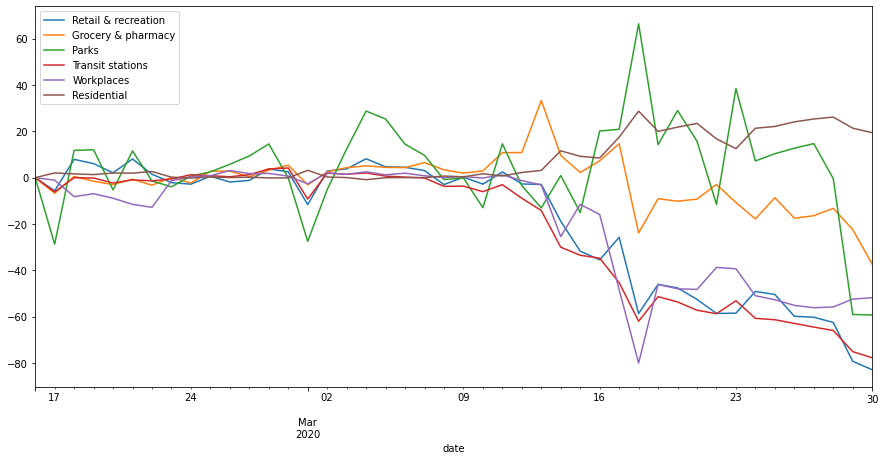

In [5]:
def get_data_by_country(country):
    data_by_country = df[df["country"] == country]
    return pd.DataFrame(data_by_country[LABELS].values, index=data_by_country["date"], columns=LABELS)

get_data_by_country("IRL").plot(figsize=(15,7))

In [6]:
df.to_csv("data/mobility.csv", index=False)